# Quantized Low-Rank Adapters (QLoRA)

Paper: https://arxiv.org/pdf/2305.14314

PEFT library guide: https://huggingface.co/docs/peft/en/developer_guides/lora#lora

Let's start with a review of quantization. A naive quantization scheme from `fp32` to `int8` would simply rescale the inputs before rounding, and would look like this:

$$
\mathbf{X}^{\mathrm{Int8}}=\operatorname{round}\left(\frac{127}{\operatorname{absmax}\left(\mathbf{X}^{\mathrm{FP} 32}\right)} \mathbf{X}^{\mathrm{FP} 32}\right)=\operatorname{round}\left(c^{\mathrm{FP} 32} \cdot \mathbf{X}^{\mathrm{FP} 32}\right)
$$

where
- $\mathbf{X}^{\mathrm{FP} 32}$ is an input tensor (in precision `fp32`),
- 127 is the maximum value of an `int8` signed integer using 8 bits (replace by $2^{n_{\text{bits}}-1}-1$ if $n_{\text{bits}}\neq 8$), and
- $\operatorname{absmax}\left(\mathbf{X}^{\mathrm{FP} 32}\right)$ is the maximum (absolute) value of the input tensor,
- $c^{\mathrm{FP} 32}$ is called the "rescaling factor".

Let's see the kind of approximations that are made with this quantization scheme.

In [1]:
%pip install -q accelerate bitsandbytes trl peft transformers

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
class Quantization:
    """Implements "naive" integer quantization with rescaling."""
    def __init__(self, bits=4):
        self.bits = bits
        self.quantization_scale = None

    def quantize(self, X):
        """The quantization scale is computed during quantization, and is needed for
        dequantization (notably, computes the absmax of the input tensor.)"""
        self.quantization_scale = (2**(self.bits - 1) - 1)/np.abs(X).max()
        return np.round(self.quantization_scale * X)

    def dequantize(self, quantized_value):
        """Restore initial values"""
        return quantized_value / self.quantization_scale

quant = Quantization(bits=4)
X = np.random.uniform(-1, 1, 10)
print(f"Input tensor: {X}")
X_quant = quant.quantize(X)
print(f"Quantized: {X_quant}")
print(f"Dequantized: {quant.dequantize(X_quant)}")

Input tensor: [ 0.40693103 -0.50388391  0.69383667  0.70399342  0.30322119 -0.87351089
 -0.42423928 -0.52456735  0.84818582 -0.26868545]
Quantized: [ 3. -4.  6.  6.  2. -7. -3. -4.  7. -2.]
Dequantized: [ 0.37436181 -0.49914908  0.74872362  0.74872362  0.24957454 -0.87351089
 -0.37436181 -0.49914908  0.87351089 -0.24957454]


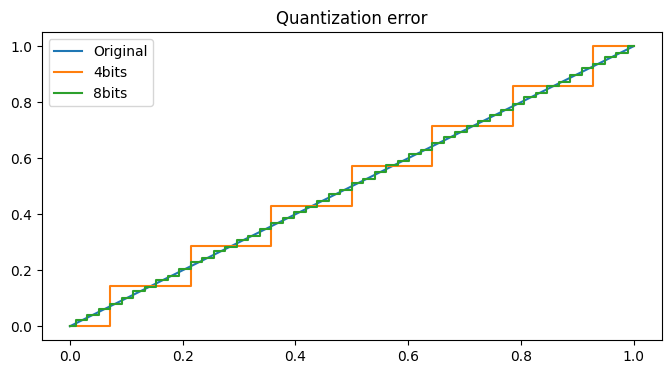

In [4]:
x = np.linspace(0, 1., 50)

quant4 = Quantization(bits=4)
quant8 = Quantization(bits=8)

y_4bits = quant4.dequantize(quant4.quantize(x))
y_8bits = quant8.dequantize(quant8.quantize(x))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, x, label="Original")
ax.step(x, y_4bits, label="4bits", where="mid")
ax.step(x, y_8bits, label="8bits", where="mid")
ax.set_title("Quantization error")
plt.legend()

In [5]:
from huggingface_hub import login
login()

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# https://huggingface.co/docs/transformers/en/peft#train-a-peft-adapter
# model_name = "bigscience/bloomz-560m"
# target_modules = ["query_key_value"]

model_name = "meta-llama/Meta-Llama-3-8B"
target_modules = ["q_proj", "v_proj"]

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)


model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Dataset
We'll fine-tune Llama3 on the following math problem dataset:
https://huggingface.co/datasets/microsoft/orca-math-word-problems-200k

In [8]:
from datasets import load_dataset

dataset = load_dataset("microsoft/orca-math-word-problems-200k")
dataset["train"][0]

{'question': 'Jungkook is the 5th place. Find the number of people who crossed the finish line faster than Jungkook.',
 'answer': 'If Jungkook is in 5th place, then 4 people crossed the finish line faster than him.'}

In [9]:
dataset["train"][10]

{'question': 'This year, the age difference between Minsu and his mother is 28 years old, and after 13 years, the age of his mother will be twice that of Minsu. Find the age of Minsu this year.',
 'answer': "Let's denote Minsu's current age as M and his mother's current age as M_m.\n\nAccording to the information given, we have two equations:\n\n1) M_m - M = 28 (The age difference between Minsu and his mother is 28 years)\n\n2) M_m + 13 = 2(M + 13) (After 13 years, the mother's age will be twice Minsu's age)\n\nNow, let's solve these equations step by step.\n\nFrom equation 1, we can express M_m in terms of M:\n\nM_m = M + 28\n\nNow, let's substitute M_m in equation 2 with the expression we found from equation 1:\n\n(M + 28) + 13 = 2(M + 13)\n\nSimplify the equation:\n\nM + 41 = 2M + 26\n\nNow, let's solve for M:\n\n2M - M = 41 - 26\nM = 15\n\nSo, Minsu is currently 15 years old."}

In [10]:
# From: https://huggingface.co/docs/trl/en/sft_trainer#add-special-tokens-for-chat-format
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['question'])):
        text = f"### Question: {example['question'][i]}\n ### Answer: {example['answer'][i]}"
        output_texts.append(text)
    return output_texts

def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5,
        early_stopping=False,
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

question = dataset["train"][10]["question"]
print(f"Question: {question}")
question = formatting_prompts_func({
    "question": [question],
    "answer": [""],
})
input_sentences = tokenizer(question, return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True)[0])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: This year, the age difference between Minsu and his mother is 28 years old, and after 13 years, the age of his mother will be twice that of Minsu. Find the age of Minsu this year.
### Question: This year, the age difference between Minsu and his mother is 28 years old, and after 13 years, the age of his mother will be twice that of Minsu. Find the age of Minsu this year.
 ### Answer: 16

#### Solution:

Let us assume x to represent Min Su's current age.

Therefore,

Now we know from question statement 

Also given in problem,

Hence proved


## Fine-Tuning.

Let's first try to fine-tune the entire model.

In [11]:
from transformers import (
    DataCollatorForLanguageModeling, TrainingArguments, Trainer
)
from peft import LoraConfig, get_peft_model

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir=".",
    # auto_find_batch_size=True,
    learning_rate=2e-4,
    num_train_epochs=1
)



lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model.add_adapter(lora_config)

tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model,
    args=training_args,
    train_dataset=dataset["train"],
    formatting_func=formatting_prompts_func,
    tokenizer=tokenizer,
    data_collator=data_collator,
    peft_config=lora_config,
)

# model = get_peft_model(model, lora_config)
# model.print_trainable_parameters()
trainer.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 268.00 MiB. GPU 

In [ ]:
question = dataset["train"][10]["question"]
print(f"Question: {question}")
question = formatting_prompts_func({
    "question": [question],
    "answer": [""],
})
input_sentences = tokenizer(question, return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True)[0])